# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from time import time
from tqdm import tqdm
import os

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above cells 
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:31<00:00, 2807.12it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [23]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:22<00:00, 3936.66it/s]


In [24]:
preprocessed_summary[0]

'made china'

## [3.].  Split Dataset into Train and Test

In [25]:
from sklearn import model_selection as ms
y=final['Score'][:100000]
dw_train,dw_test,y_train,y_test=ms.train_test_split(preprocessed_reviews, y, stratify=y, test_size=0.2, random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer(dtype='float') #in scikit-learn
d_train =count_vect.fit_transform(dw_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaah', 'aaaah', 'aaaand']


In [27]:
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = count_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (70218, 49031)
the shape of test-text BOW vectorizer  (17555, 49031)


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
d_train_gram = count_vect_gram.fit_transform(dw_train)

In [29]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_gram))
print("the shape of train-text BOW vectorizer ",d_train_gram.get_shape())

d_test_gram = count_vect_gram.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_gram.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (70218, 5000)
the shape of test-text BOW vectorizer  (17555, 5000)


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
d_train_tf =tf_idf_vect.fit_transform(dw_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']


In [31]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_tf))
print("the shape of train-text BOW vectorizer ",d_train_tf.get_shape())

d_test_tf = tf_idf_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_tf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (70218, 41295)
the shape of test-text BOW vectorizer  (17555, 41295)


## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
train_list=[]
test_list=[]
for sent in dw_train:
    train_list.append(sent.split())
for sent in dw_test:
    test_list.append(sent.split())

In [33]:
# Using Google News Word2Vectors
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(train_list,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8297212719917297), ('awesome', 0.8250125050544739), ('fantastic', 0.821380615234375), ('excellent', 0.8032631874084473), ('wonderful', 0.793063223361969), ('terrific', 0.7889218330383301), ('amazing', 0.750499427318573), ('perfect', 0.7422112226486206), ('nice', 0.7071204781532288), ('decent', 0.688544750213623)]
[('greatest', 0.7528401017189026), ('best', 0.7175250053405762), ('closest', 0.6731676459312439), ('tastiest', 0.6690865159034729), ('ive', 0.6576330661773682), ('nastiest', 0.6529994606971741), ('smoothest', 0.6471142172813416), ('softest', 0.6301393508911133), ('disgusting', 0.606341540813446), ('worse', 0.5917190909385681)]


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15666
sample words  ['needless', 'say', 'saw', 'instantly', 'started', 'remembering', 'gummi', 'peach', 'rings', 'local', 'pizza', 'polar', 'young', 'boy', 'even', 'tasted', 'first', 'time', 'years', 'gave', 'bag', 'one', 'cousins', 'must', 'thats', 'many', 'think', 'happy', 'thought', 'childhood', 'small', 'tear', 'eye', 'almost', 'brought', 'back', 'happiness', 'youth', 'girls', 'past', 'broken', 'hearts', 'hassle', 'worry', 'everyday', 'life', 'could', 'see', 'people', 'outside']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_train_w2 = [];
for sent in tqdm(train_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_train_w2.append(sent_vec)
print(len(d_train_w2))
print(len(d_train_w2[0]))

100%|██████████| 70218/70218 [02:22<00:00, 493.61it/s]

70218
50


In [36]:
# average Word2Vec
# compute average word2vec for each review in test dataset.
#test dataset
d_test_w2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_test_w2.append(sent_vec)
print(len(d_test_w2))
print(len(d_test_w2[0]))

100%|██████████| 17555/17555 [00:37<00:00, 462.67it/s]

17555
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

d_train_tf_wt = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_train_tf_wt.append(sent_vec)
    row += 1

100%|██████████| 70218/70218 [32:05<00:00, 36.47it/s]  


In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

#test dataset
d_test_tf_wt = [];
row=0;
for sent in tqdm(test_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_test_tf_wt.append(sent_vec)
    row += 1

100%|██████████| 17555/17555 [08:05<00:00, 36.14it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [40]:
# Please write all the code with proper documentation
def cv_lr_grid(d_train, y_train, regularizer):
    import warnings
    warnings.filterwarnings('ignore')

    #defining 'c' for grid-search
    param= {'C':[0.0001,0.001,0.01,1,10,100,1000,10000],'penalty':[regularizer]}

    #Using Grid Search to get Best C=1/alpha
    start = time()
    lr= LogisticRegression(class_weight='balanced')
    clf = GridSearchCV(lr,param, cv=5,scoring='roc_auc')
    clf.fit(d_train, y_train)
    print("Time elapsed : %.2f Seconds" % (time() - start))
    print(" optimal alpha using Grid Search is " + str(clf.best_params_))
    optimal_alpha_grid=clf.best_params_.get('C')
    return optimal_alpha_grid

In [41]:
#plot confusion matrix and print report
def report(x,y,model):
    y_true, y_pred = y, model.predict(x)
    print(classification_report(y_true, y_pred))
    print()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("The value of TPR is %.3f" %(tp/(fn+tp)) +
          "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
         "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
         "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
         
    cm=confusion_matrix(y_true, y_pred)
    ax=sns.heatmap(cm,annot=True,fmt="d")
    ax.set(xlabel='Predicted', ylabel='Actual')
    print()
    print("The roc auc score is %f" %roc_auc_score(y_true, model.predict_proba(x)[:,1]))

In [42]:
#to test multicollinearity
def pertubation(w_old,c,d_train,y_train):
    d_train_new=d_train
    d_train_new.data=d_train.data+0.00001
    lr_l2=LogisticRegression(penalty='l2',C=c)
    lr_l2.fit(d_train_new,y_train)
    w_new = lr_l2.coef_
    #to eliminate division by zero
    w_old=w_old+0.000001
    w_new=w_new+0.000001
    change=((abs(w_old-w_new))/w_old)*100
    print (change.shape)
    return change

In [43]:
##plot inspired from this blog : https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_TopWords(classifier, feature_names, top_features): 
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [44]:
def plotROC(d_trai,y_trai,d_tes,y_tes,model):
    train_score = model.predict_proba(d_trai)[:,1]
    test_score = model.predict_proba(d_tes)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
    fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic Curve')
    plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, label = 'AUC Test = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [45]:
def plotTrainvsTestAUC(d_trai,y_trai,d_tes,y_tes,penalty):
    import warnings
    from math import log
    warnings.filterwarnings('ignore')
    auc_train_list=list()
    auc_test_list=list()
    param=[0.0001,0.001,0.01,1,10,100,1000,10000]
    x=list()
    for i in tqdm(param):
        x.append(log(i,10))
        model=LogisticRegression(penalty=penalty,C=i,class_weight='balanced')
        model.fit(d_trai,y_trai)
        train_score = model.predict_proba(d_trai)[:,1]
        test_score = model.predict_proba(d_tes)[:,1]
        fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
        fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
        auc_train_list.append(auc(fpr_train, tpr_train))
        auc_test_list.append(auc(fpr_test, tpr_test))
    plt.title('Train AUC Score vs Test AUC Score')
    plt.plot(x, auc_train_list, label = 'Train AUC Score')
    plt.plot(x, auc_test_list, label = 'Test AUC Score')
    plt.legend(loc = 'lower right')
    #plt.ylim([0, 1])
    plt.xlabel('Log OF C')
    plt.ylabel('AUC Score')
    plt.show()

In [46]:
#c_grid=cv_lr_grid(d_train,y_train,'l1')
c_grid=1

              precision    recall  f1-score   support

           0       0.76      0.98      0.85     11345
           1       1.00      0.94      0.97     58873

   micro avg       0.95      0.95      0.95     70218
   macro avg       0.88      0.96      0.91     70218
weighted avg       0.96      0.95      0.95     70218


The value of TPR is 0.940
The value of TNR is 0.976
The value of FPR is 0.024
The value of FNR is 0.060

The roc auc score is 0.989504


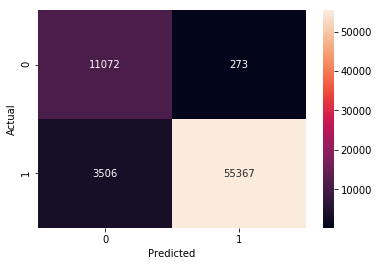

In [47]:
##confusion matrix and report on Train Data
#L1 regulariser
lr_l1_bow=LogisticRegression(penalty='l1',C=1,class_weight='balanced')
lr_l1_bow.fit(d_train,y_train)
report(d_train,y_train,lr_l1_bow)

100%|██████████| 8/8 [54:30<00:00, 842.89s/it]


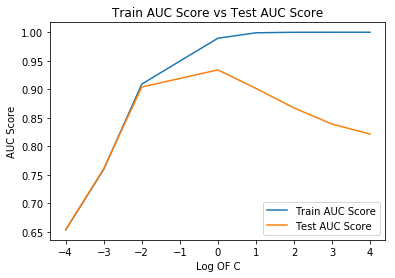

In [48]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train,y_train,d_test,y_test,"l1")

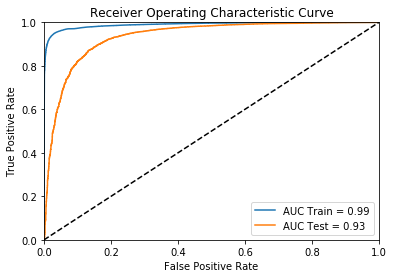

In [49]:
#plot roc curve for train and test data
plotROC(d_train,y_train,d_test,y_test,lr_l1_bow)

              precision    recall  f1-score   support

           0       0.65      0.81      0.73      2836
           1       0.96      0.92      0.94     14719

   micro avg       0.90      0.90      0.90     17555
   macro avg       0.81      0.87      0.83     17555
weighted avg       0.91      0.90      0.90     17555


The value of TPR is 0.917
The value of TNR is 0.815
The value of FPR is 0.185
The value of FNR is 0.083

The roc auc score is 0.934031


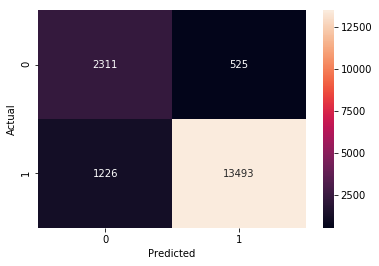

In [50]:
##confusion matrix and report on Test Data
report(d_test,y_test,lr_l1_bow)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [51]:
# Please write all the code with proper documentation
#getting roc_auc_score, balanced accuracy score and sparcity of model
def score_sparcity(c,d_train,y_train):
    import warnings
    warnings.filterwarnings('ignore')
    lr_l1=LogisticRegression(penalty='l1',C=c)
    lr_l1.fit(d_train,y_train)
    w = lr_l1.coef_
    y_true, y_pred = y_train, lr_l1.predict_proba(d_train)[:,1]
    print("The roc auc score is %f" %roc_auc_score(y_true, y_pred))
    print("The Sparcity is %d" %np.count_nonzero(w))

In [52]:
#c=1/alpha
c=1000
score_sparcity(c,d_train,y_train)

The roc auc score is 0.999954
The Sparcity is 20389


In [53]:
c=100
score_sparcity(c,d_train,y_train)

The roc auc score is 0.999888
The Sparcity is 12950


In [54]:
c=10
score_sparcity(c,d_train,y_train)

The roc auc score is 0.998605
The Sparcity is 10830


In [55]:
c=1
score_sparcity(c,d_train,y_train)

The roc auc score is 0.983597
The Sparcity is 5080


In [56]:
c=0.1
score_sparcity(c,d_train,y_train)

The roc auc score is 0.947652
The Sparcity is 956


In [57]:
c=0.01
score_sparcity(c,d_train,y_train)

The roc auc score is 0.890877
The Sparcity is 141


In [58]:
c=0.001
score_sparcity(c,d_train,y_train)

The roc auc score is 0.732088
The Sparcity is 6


In [59]:
c=0.0001
score_sparcity(c,d_train,y_train)

The roc auc score is 0.500000
The Sparcity is 0


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [60]:
# Please write all the code with proper documentation
#calling the function with penalty = l2
c_grid_l2=cv_lr_grid(d_train,y_train,'l2')

Time elapsed : 402.81 Seconds
 optimal alpha using Grid Search is {'C': 0.01, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.61      0.90      0.72     11345
           1       0.98      0.89      0.93     58873

   micro avg       0.89      0.89      0.89     70218
   macro avg       0.79      0.89      0.83     70218
weighted avg       0.92      0.89      0.90     70218


The value of TPR is 0.888
The value of TNR is 0.897
The value of FPR is 0.103
The value of FNR is 0.112

The roc auc score is 0.955622


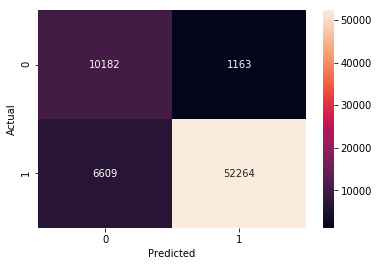

In [61]:
##confusion matrix and report on Train Data
#L2 regulariser
lr_l2_bow=LogisticRegression(penalty='l2',C=c_grid_l2,class_weight='balanced')
lr_l2_bow.fit(d_train,y_train)
report(d_train,y_train,lr_l2_bow)

100%|██████████| 8/8 [01:42<00:00, 18.87s/it]


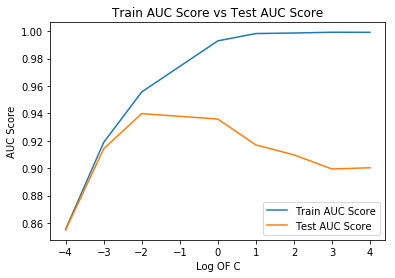

In [62]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train,y_train,d_test,y_test,"l2")

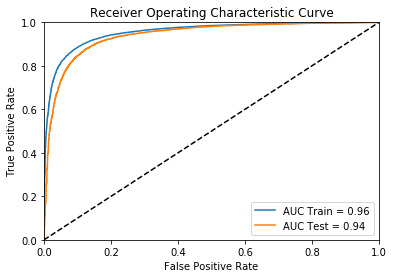

In [63]:
#plot roc curve for train and test data
plotROC(d_train,y_train,d_test,y_test,lr_l2_bow)

              precision    recall  f1-score   support

           0       0.59      0.87      0.70      2836
           1       0.97      0.88      0.93     14719

   micro avg       0.88      0.88      0.88     17555
   macro avg       0.78      0.88      0.81     17555
weighted avg       0.91      0.88      0.89     17555


The value of TPR is 0.882
The value of TNR is 0.869
The value of FPR is 0.131
The value of FNR is 0.118

The roc auc score is 0.939782


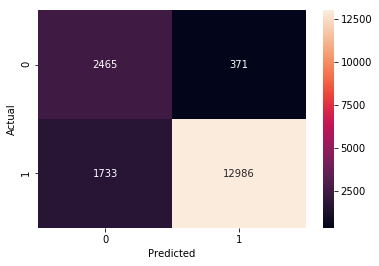

In [64]:
##confusion matrix and report on Test Data
report(d_test,y_test,lr_l2_bow)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [65]:
# Please write all the code with proper documentation
#calling the pertubation function with 
lr_l2_bow=LogisticRegression(penalty='l2',C=c_grid_l2)
lr_l2_bow.fit(d_train,y_train)
w_old = lr_l2_bow.coef_
change=pertubation(w_old,c_grid_l2,d_train,y_train)

(1, 49031)


In [66]:
##Creating a dictionary of features and the corresponding weights
feature_names = count_vect.get_feature_names()
feature_dict = dict()
for weight, feature in zip(w_old[0], feature_names):
    feature_dict[weight] = feature

In [67]:
#getting 10th, 20th, .... Percentiles
x_0=0
for i in range(0,101,10):
    x_1=np.percentile(change,i)-x_0
    print()
    print("The %dth percentile is %f and difference is %f"%(i,np.percentile(change,i),x_1))
    x_0=np.percentile(change,i)


The 0th percentile is -2.301190 and difference is -2.301190

The 10th percentile is -0.000932 and difference is 2.300258

The 20th percentile is -0.000492 and difference is 0.000440

The 30th percentile is 0.000004 and difference is 0.000496

The 40th percentile is 0.000174 and difference is 0.000170

The 50th percentile is 0.000343 and difference is 0.000169

The 60th percentile is 0.000514 and difference is 0.000170

The 70th percentile is 0.000694 and difference is 0.000181

The 80th percentile is 0.000899 and difference is 0.000205

The 90th percentile is 0.001211 and difference is 0.000312

The 100th percentile is 0.499700 and difference is 0.498489


In [68]:
#getting 90th, 91st, 92nd .. percentiles
#since there is a sudden change from 90th to 100th percentile
x_0=0
for i in range(90,101):
    x_1=np.percentile(change,i)-x_0
    print()
    print("The %dth percentile is %f and difference is %f"%(i,np.percentile(change,i),x_1))
    x_0=np.percentile(change,i)


The 90th percentile is 0.001211 and difference is 0.001211

The 91th percentile is 0.001263 and difference is 0.000052

The 92th percentile is 0.001324 and difference is 0.000061

The 93th percentile is 0.001394 and difference is 0.000070

The 94th percentile is 0.001494 and difference is 0.000100

The 95th percentile is 0.001609 and difference is 0.000115

The 96th percentile is 0.001778 and difference is 0.000169

The 97th percentile is 0.002044 and difference is 0.000266

The 98th percentile is 0.002482 and difference is 0.000439

The 99th percentile is 0.004079 and difference is 0.001597

The 100th percentile is 0.499700 and difference is 0.495621


In [69]:
#getting 99.0th, 99.1th, 99.2th, 99.3th Percentiles
x_0=0
for i in range(990,1001):
    x_1=np.percentile(change,i/10)-x_0
    print()
    print("The %.1fth percentile is %f and difference is %f"%(i/10,np.percentile(change,i/10),x_1))
    x_0=np.percentile(change,i/10)


The 99.0th percentile is 0.004079 and difference is 0.004079

The 99.1th percentile is 0.004485 and difference is 0.000405

The 99.2th percentile is 0.005148 and difference is 0.000663

The 99.3th percentile is 0.005719 and difference is 0.000571

The 99.4th percentile is 0.006641 and difference is 0.000922

The 99.5th percentile is 0.008052 and difference is 0.001411

The 99.6th percentile is 0.010323 and difference is 0.002271

The 99.7th percentile is 0.013851 and difference is 0.003528

The 99.8th percentile is 0.019639 and difference is 0.005787

The 99.9th percentile is 0.039889 and difference is 0.020250

The 100.0th percentile is 0.499700 and difference is 0.459811


In [70]:
#creating list of weights whose %change in weight is 
#more than the threshold value i.e. 0.039889
list_=list()
for i,j in zip(change[0],w_old[0]):
    if(i > 0.039889):
        list_.append(j)

In [71]:
##features whose %change in weight is more than the threshold value
fea=set()
for i in list_:
    fea.add(feature_dict.get(i))
print(fea)

{'bragged', 'sw', 'handed', 'nectar', 'amidst', 'enhancers', 'tmj', 'redken', 'crispness', 'magic', 'ammonia', 'orgainic', 'saffron', 'resounding', 'caloriesi', 'labrador', 'mauritius', 'choir', 'eve', 'supremely', 'vitamins', 'squeak', 'beers', 'purports', 'infuse', 'random', 'malted', 'jamaica', 'ing', 'condenser', 'pectin', 'fur', 'gobs', 'increments', 'rightfully', 'push', 'coughing', 'ohh', 'hoo', 'seasonings', 'clearer', 'youtube', 'zipfizz', 'aw', 'israel', 'tasts', 'teabag', 'lifted', 'dinos', 'oxidized'}


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation
##mapping features and weights
##sorting by weights (indices) and getting the last 10 weights
pos = sorted(zip(w_old[0], feature_names))
print(pos[-10:])

[(0.6114088905170614, 'highly'), (0.6204213399892601, 'amazing'), (0.6457291750363358, 'nice'), (0.6987319405092132, 'wonderful'), (0.7474323615936173, 'excellent'), (0.7753629608468008, 'loves'), (0.8219826824207692, 'best'), (0.8321915383804527, 'perfect'), (0.9469996563341293, 'great'), (0.9886581019312854, 'delicious')]


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [73]:
# Please write all the code with proper documentation
##mapping features and weights
##sorting by weights (indices) and getting the first 10 weights
pos = sorted(zip(w_old[0], feature_names))
print(pos[:10])

[(-0.9407378041343881, 'disappointed'), (-0.8353100302464732, 'worst'), (-0.7798317335530787, 'disappointing'), (-0.7695282039722928, 'terrible'), (-0.7664644826647105, 'awful'), (-0.7203113139346708, 'horrible'), (-0.6638935781233972, 'money'), (-0.6430922110271099, 'waste'), (-0.6404387467407188, 'unfortunately'), (-0.6072880167497035, 'threw')]


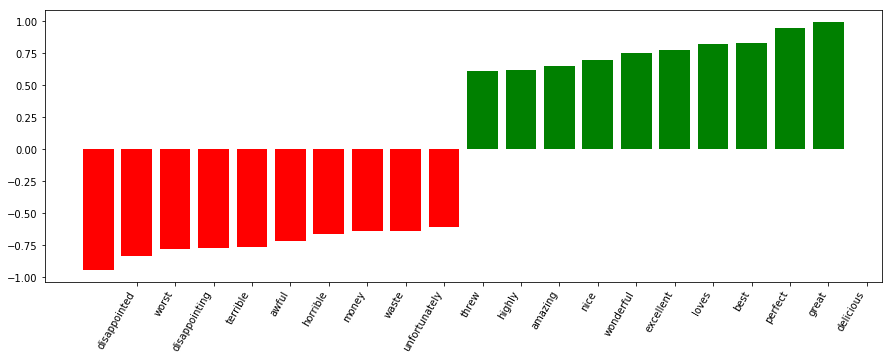

In [74]:
plot_TopWords(lr_l2_bow,feature_names,10)

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [75]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_tf as training dataset
#and regulariser as L1
c_grid_tf_l1=cv_lr_grid(d_train_tf,y_train,'l1')

Time elapsed : 50.48 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l1'}


              precision    recall  f1-score   support

           0       0.70      0.93      0.80     11345
           1       0.99      0.92      0.95     58873

   micro avg       0.92      0.92      0.92     70218
   macro avg       0.84      0.93      0.87     70218
weighted avg       0.94      0.92      0.93     70218


The value of TPR is 0.921
The value of TNR is 0.934
The value of FPR is 0.066
The value of FNR is 0.079

The roc auc score is 0.978268


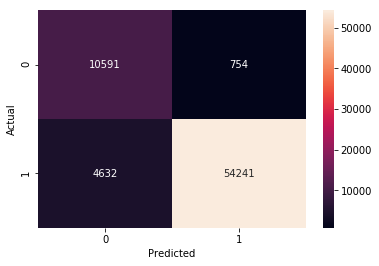

In [76]:
##confusion matrix and report on Train Data
#L1 regulariser
lr_l1_tf=LogisticRegression(penalty='l1',C=c_grid_tf_l1,class_weight='balanced')
lr_l1_tf.fit(d_train_tf,y_train)
report(d_train_tf,y_train,lr_l1_tf)

100%|██████████| 8/8 [00:13<00:00,  2.12s/it]


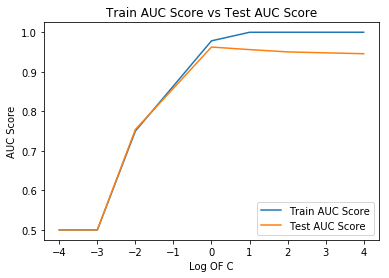

In [77]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_tf,y_train,d_test_tf,y_test,"l1")

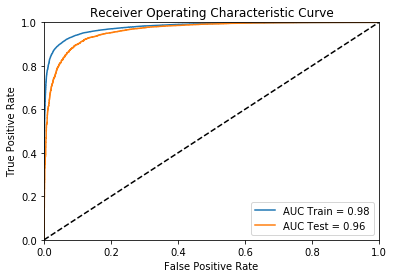

In [78]:
#plot roc curve for train and test data
plotROC(d_train_tf,y_train,d_test_tf,y_test,lr_l1_tf)

              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2836
           1       0.98      0.91      0.94     14719

   micro avg       0.91      0.91      0.91     17555
   macro avg       0.82      0.90      0.85     17555
weighted avg       0.93      0.91      0.91     17555


The value of TPR is 0.911
The value of TNR is 0.889
The value of FPR is 0.111
The value of FNR is 0.089

The roc auc score is 0.962558


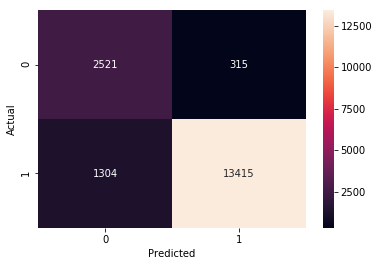

In [79]:
##confusion matrix and report on Test Data
report(d_test_tf,y_test,lr_l1_tf)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [80]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_tf as training dataset
#and regulariser as L2
c_grid_tf=cv_lr_grid(d_train_tf,y_train,'l2')

Time elapsed : 75.89 Seconds
 optimal alpha using Grid Search is {'C': 10, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11345
           1       1.00      0.98      0.99     58873

   micro avg       0.98      0.98      0.98     70218
   macro avg       0.95      0.99      0.97     70218
weighted avg       0.98      0.98      0.98     70218


The value of TPR is 0.978
The value of TNR is 0.998
The value of FPR is 0.002
The value of FNR is 0.022

The roc auc score is 0.998795


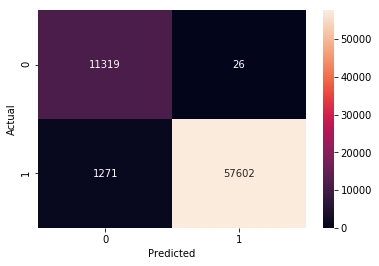

In [81]:
##confusion matrix and report on Train Data
#L2 regulariser
lr_l2_tf=LogisticRegression(penalty='l2',C=c_grid_tf,class_weight='balanced')
lr_l2_tf.fit(d_train_tf,y_train)
report(d_train_tf,y_train,lr_l2_tf)

100%|██████████| 8/8 [00:22<00:00,  4.23s/it]


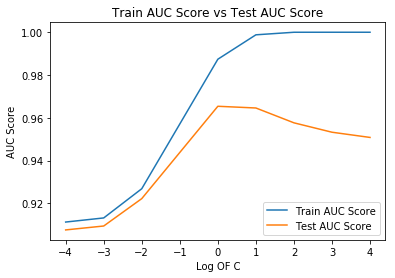

In [82]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_tf,y_train,d_test_tf,y_test,"l2")

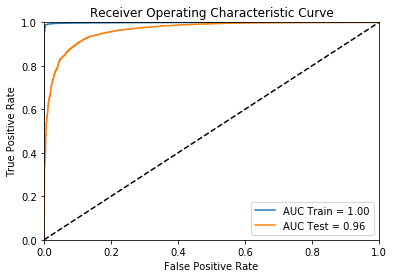

In [83]:
#plot roc curve for train and test data
plotROC(d_train_tf,y_train,d_test_tf,y_test,lr_l2_tf)

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      2836
           1       0.97      0.94      0.96     14719

   micro avg       0.93      0.93      0.93     17555
   macro avg       0.85      0.89      0.87     17555
weighted avg       0.93      0.93      0.93     17555


The value of TPR is 0.943
The value of TNR is 0.842
The value of FPR is 0.158
The value of FNR is 0.057

The roc auc score is 0.964570


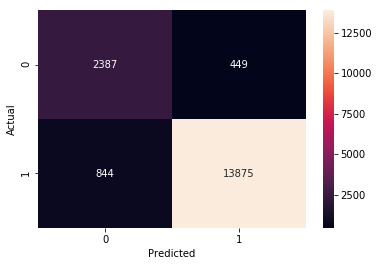

In [84]:
##confusion matrix and report on Test Data
report(d_test_tf,y_test,lr_l2_tf)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [85]:
w_ = lr_l2_tf.coef_
feature_names_tf= tf_idf_vect.get_feature_names()
##mapping features and weights
##sorting by weights (indices) and getting the last 10 weights
pos = sorted(zip(w_[0], feature_names))
print(pos[-10:])

[(10.691800064577436, 'korr'), (10.799203403467859, 'immaculate'), (11.690776618810952, 'spraying'), (12.076925918748461, 'alginate'), (12.675770668052566, 'mired'), (13.9505875794831, 'fantabulous'), (14.678643916081539, 'avocados'), (15.790187242933294, 'lens'), (17.35913405815587, 'compromises'), (18.14717715046899, 'fitzroy')]


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [86]:
# Please write all the code with proper documentation
##mapping features and weights
##sorting by weights (indices) and getting the first 10 weights
pos = sorted(zip(w_old[0], feature_names))
print(pos[:10])

[(-0.9407378041343881, 'disappointed'), (-0.8353100302464732, 'worst'), (-0.7798317335530787, 'disappointing'), (-0.7695282039722928, 'terrible'), (-0.7664644826647105, 'awful'), (-0.7203113139346708, 'horrible'), (-0.6638935781233972, 'money'), (-0.6430922110271099, 'waste'), (-0.6404387467407188, 'unfortunately'), (-0.6072880167497035, 'threw')]


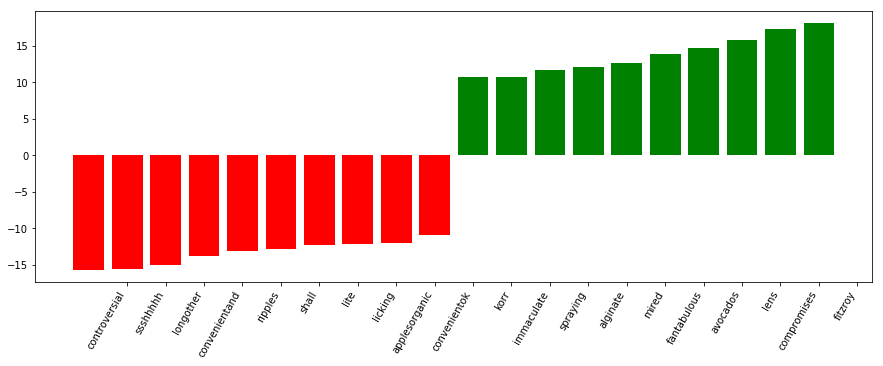

In [87]:
plot_TopWords(lr_l2_tf,feature_names,10)

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [88]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_w2 as training dataset
#and regulariser as L1
c_grid_l1_w2=cv_lr_grid(d_train_w2,y_train,'l1')

Time elapsed : 367.96 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l1'}


              precision    recall  f1-score   support

           0       0.46      0.85      0.60     11345
           1       0.96      0.81      0.88     58873

   micro avg       0.82      0.82      0.82     70218
   macro avg       0.71      0.83      0.74     70218
weighted avg       0.88      0.82      0.84     70218


The value of TPR is 0.810
The value of TNR is 0.846
The value of FPR is 0.154
The value of FNR is 0.190

The roc auc score is 0.905789


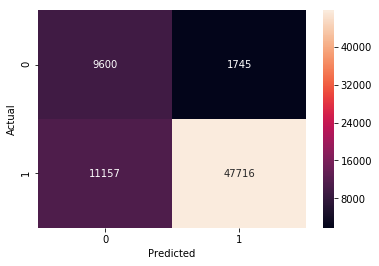

In [89]:
##confusion matrix and report on Train Data
#L1 regulariser
lr_l1_w2=LogisticRegression(penalty='l1',C=c_grid_l1_w2,class_weight='balanced')
lr_l1_w2.fit(d_train_w2,y_train)
report(d_train_w2,y_train,lr_l1_w2)

100%|██████████| 8/8 [01:28<00:00, 14.32s/it]


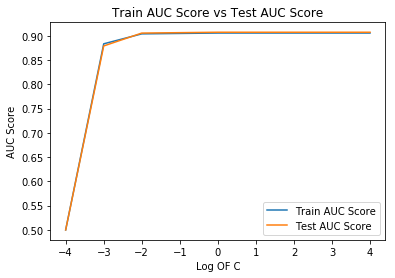

In [90]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_w2,y_train,d_test_w2,y_test,"l1")

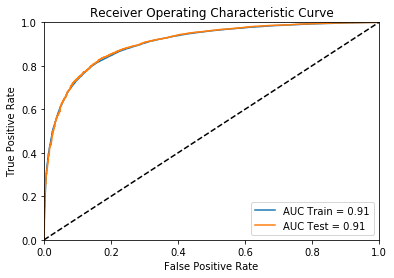

In [91]:
#plot roc curve for train and test data
plotROC(d_train_w2,y_train,d_test_w2,y_test,lr_l1_w2)

              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2836
           1       0.97      0.81      0.88     14719

   micro avg       0.82      0.82      0.82     17555
   macro avg       0.71      0.83      0.74     17555
weighted avg       0.88      0.82      0.83     17555


The value of TPR is 0.809
The value of TNR is 0.852
The value of FPR is 0.148
The value of FNR is 0.191

The roc auc score is 0.907432


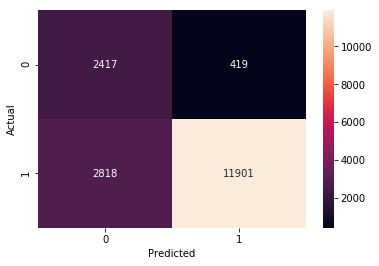

In [92]:
##confusion matrix and report on Test
report(d_test_w2,y_test,lr_l1_w2)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [93]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_w2 as training dataset
#and regulariser as L2
c_grid_w2=cv_lr_grid(d_train_w2,y_train,'l2')

Time elapsed : 49.99 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.46      0.85      0.60     11345
           1       0.96      0.81      0.88     58873

   micro avg       0.82      0.82      0.82     70218
   macro avg       0.71      0.83      0.74     70218
weighted avg       0.88      0.82      0.84     70218


The value of TPR is 0.810
The value of TNR is 0.846
The value of FPR is 0.154
The value of FNR is 0.190

The roc auc score is 0.905787


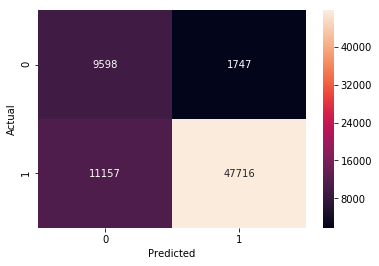

In [94]:
##confusion matrix and report on Train Data
#L2 regulariser
lr_l2_w2=LogisticRegression(penalty='l2',C=c_grid_w2,class_weight='balanced')
lr_l2_w2.fit(d_train_w2,y_train)
report(d_train_w2,y_train,lr_l2_w2)

100%|██████████| 8/8 [00:11<00:00,  1.62s/it]


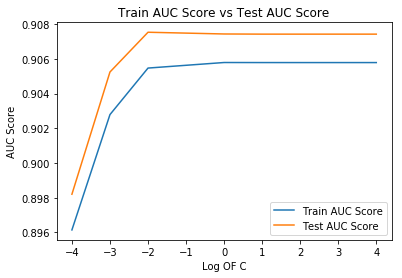

In [95]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_w2,y_train,d_test_w2,y_test,"l2")

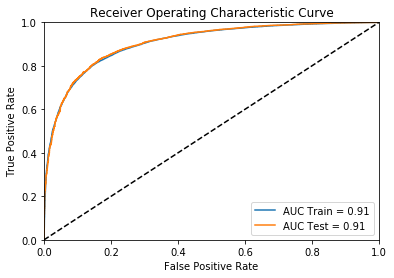

In [96]:
#plot roc curve for train and test data
plotROC(d_train_w2,y_train,d_test_w2,y_test,lr_l2_w2)

              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2836
           1       0.97      0.81      0.88     14719

   micro avg       0.82      0.82      0.82     17555
   macro avg       0.71      0.83      0.74     17555
weighted avg       0.88      0.82      0.83     17555


The value of TPR is 0.809
The value of TNR is 0.852
The value of FPR is 0.148
The value of FNR is 0.191

The roc auc score is 0.907430


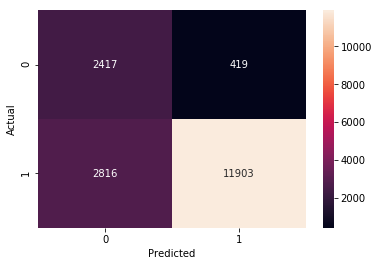

In [97]:
##confusion matrix and report on Test
report(d_test_w2,y_test,lr_l2_w2)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [98]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_tf_wt as training dataset
#and regulariser as L1
c_grid_t_wt=cv_lr_grid(d_train_tf_wt,y_train,'l1')

Time elapsed : 320.52 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l1'}


              precision    recall  f1-score   support

           0       0.43      0.82      0.56     11345
           1       0.96      0.79      0.86     58873

   micro avg       0.79      0.79      0.79     70218
   macro avg       0.69      0.80      0.71     70218
weighted avg       0.87      0.79      0.81     70218


The value of TPR is 0.787
The value of TNR is 0.819
The value of FPR is 0.181
The value of FNR is 0.213

The roc auc score is 0.883075


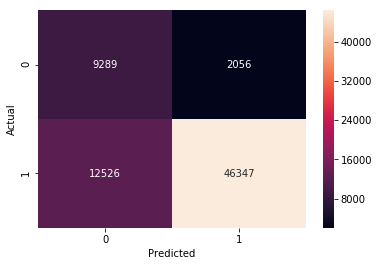

In [99]:
##confusion matrix and report on Train Data
#L1 regulariser
lr_l1_tf_wt=LogisticRegression(penalty='l1',C=c_grid_t_wt,class_weight='balanced')
lr_l1_tf_wt.fit(d_train_tf_wt,y_train)
report(d_train_tf_wt,y_train,lr_l1_tf_wt)

100%|██████████| 8/8 [01:18<00:00, 12.32s/it]


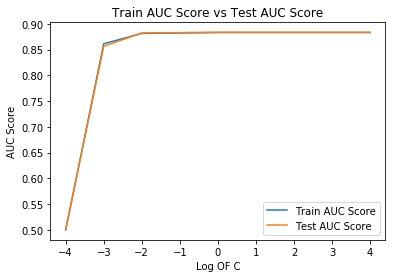

In [103]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,"l1")

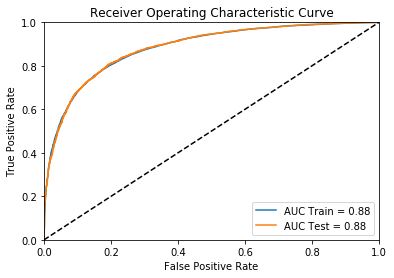

In [104]:
#plot roc curve for train and test data
plotROC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,lr_l1_tf_wt)

              precision    recall  f1-score   support

           0       0.43      0.82      0.56      2836
           1       0.96      0.79      0.86     14719

   micro avg       0.79      0.79      0.79     17555
   macro avg       0.69      0.80      0.71     17555
weighted avg       0.87      0.79      0.81     17555


The value of TPR is 0.786
The value of TNR is 0.822
The value of FPR is 0.178
The value of FNR is 0.214

The roc auc score is 0.883645


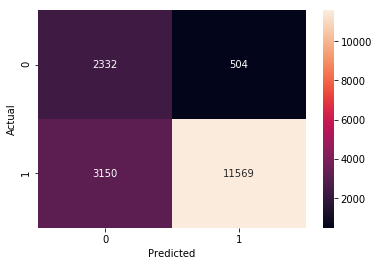

In [105]:
##confusion matrix and report on Test
report(d_test_tf_wt,y_test,lr_l1_tf_wt)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [106]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_train_tf_wt as training dataset
#and regulariser as L2
c_grid_tf_wt=cv_lr_grid(d_train_tf_wt,y_train,'l2')

Time elapsed : 55.23 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.43      0.82      0.56     11345
           1       0.96      0.79      0.86     58873

   micro avg       0.79      0.79      0.79     70218
   macro avg       0.69      0.80      0.71     70218
weighted avg       0.87      0.79      0.81     70218


The value of TPR is 0.787
The value of TNR is 0.819
The value of FPR is 0.181
The value of FNR is 0.213

The roc auc score is 0.883076


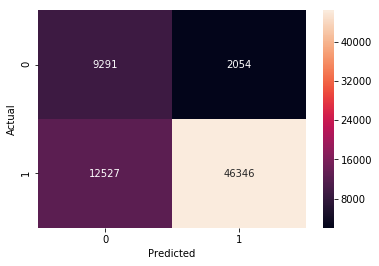

In [107]:
##confusion matrix and report on Train Data
#L2 regulariser
lr_l2_tf_wt=LogisticRegression(penalty='l2',C=c_grid_tf_wt,class_weight='balanced')
lr_l2_tf_wt.fit(d_train_tf_wt,y_train)
report(d_train_tf_wt,y_train,lr_l2_tf_wt)

100%|██████████| 8/8 [00:13<00:00,  1.83s/it]


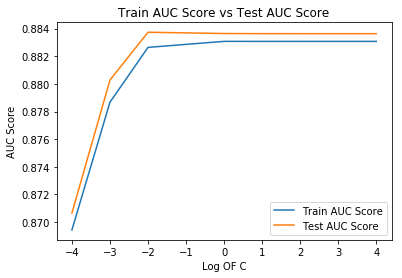

In [109]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,"l2")

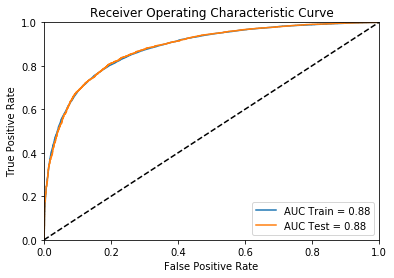

In [110]:
#plot roc curve for train and test data
plotROC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,lr_l2_tf_wt)

              precision    recall  f1-score   support

           0       0.43      0.82      0.56      2836
           1       0.96      0.79      0.86     14719

   micro avg       0.79      0.79      0.79     17555
   macro avg       0.69      0.80      0.71     17555
weighted avg       0.87      0.79      0.81     17555


The value of TPR is 0.786
The value of TNR is 0.823
The value of FPR is 0.177
The value of FNR is 0.214

The roc auc score is 0.883644


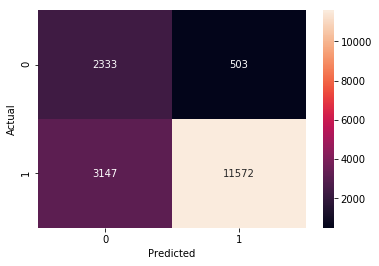

In [111]:
##confusion matrix and report on Test
report(d_test_tf_wt,y_test,lr_l2_tf_wt)

## Adding Review Summary To the Reviews

In [112]:
listA = [preprocessed_summary[i] +" " + preprocessed_reviews[i] for i in range(len(preprocessed_reviews))]
dwA_train,dwA_test,y_train,y_test=ms.train_test_split(listA, y, stratify=y, test_size=0.2, random_state=0)

In [113]:
trainA_list=[]
for sent in dwA_train:
    trainA_list.append(sent.split())
w2vA_model=Word2Vec(trainA_list,min_count=5,size=50, workers=4)
print(w2vA_model.wv.most_similar('great'))
print('='*50)
print(w2vA_model.wv.most_similar('worst'))
w2vA_words = list(w2vA_model.wv.vocab)

[('fantastic', 0.817060649394989), ('terrific', 0.8103036284446716), ('excellent', 0.8079220056533813), ('awesome', 0.8047534227371216), ('wonderful', 0.7861284613609314), ('good', 0.7792019844055176), ('perfect', 0.7489495873451233), ('nice', 0.6825402975082397), ('amazing', 0.6794854402542114), ('decent', 0.6775164008140564)]
[('greatest', 0.775356113910675), ('best', 0.71474289894104), ('closest', 0.6507704257965088), ('experienced', 0.6453039050102234), ('nastiest', 0.6343936920166016), ('ive', 0.6297587156295776), ('foul', 0.6113804578781128), ('horrible', 0.610868513584137), ('awful', 0.6074503660202026), ('terrible', 0.6055221557617188)]


In [114]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_trainA_w2 = [];
for sent in tqdm(trainA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_trainA_w2.append(sent_vec)
print(len(d_trainA_w2))
print(len(d_trainA_w2[0]))

100%|██████████| 70218/70218 [02:23<00:00, 488.29it/s]

70218
50


In [115]:
# Please write all the code with proper documentation
#calling the function cv_lr_grid with d_trainA_w2 as training dataset
#and regulariser as L1
c_gridA_l1_w2=cv_lr_grid(d_trainA_w2,y_train,'l2')

Time elapsed : 56.69 Seconds
 optimal alpha using Grid Search is {'C': 1, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.52      0.88      0.66     11345
           1       0.97      0.85      0.91     58873

   micro avg       0.85      0.85      0.85     70218
   macro avg       0.75      0.86      0.78     70218
weighted avg       0.90      0.85      0.87     70218


The value of TPR is 0.847
The value of TNR is 0.876
The value of FPR is 0.124
The value of FNR is 0.153

The roc auc score is 0.935414


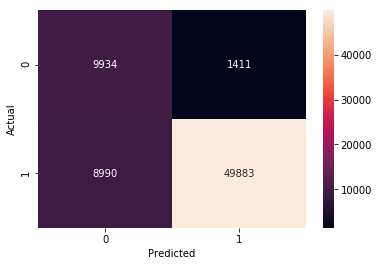

In [116]:
##confusion matrix and report on Train Data
#L2 regulariser
lr_l2_tf_=LogisticRegression(penalty='l1',C=c_gridA_l1_w2,class_weight='balanced')
lr_l2_tf_.fit(d_trainA_w2,y_train)
report(d_trainA_w2,y_train,lr_l2_tf_)

In [117]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#test dataset
testA_list=[]
for sent in dwA_test:
    testA_list.append(sent.split())
d_testA_w2 = [];
for sent in tqdm(testA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_testA_w2.append(sent_vec)
print(len(d_testA_w2))
print(len(d_testA_w2[0]))

100%|██████████| 17555/17555 [00:38<00:00, 461.16it/s]

17555
50


100%|██████████| 8/8 [00:14<00:00,  1.98s/it]


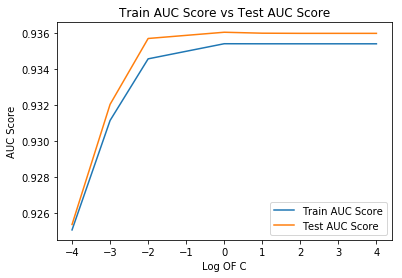

In [121]:
#train auc vs test auc curve
plotTrainvsTestAUC(d_trainA_w2,y_train,d_testA_w2,y_test,"l2")

              precision    recall  f1-score   support

           0       0.52      0.88      0.66      2836
           1       0.97      0.85      0.91     14719

   micro avg       0.85      0.85      0.85     17555
   macro avg       0.75      0.86      0.78     17555
weighted avg       0.90      0.85      0.86     17555


The value of TPR is 0.846
The value of TNR is 0.879
The value of FPR is 0.121
The value of FNR is 0.154

The roc auc score is 0.936046


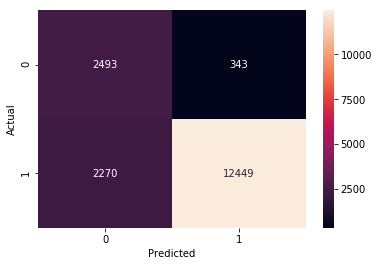

In [118]:
report(d_testA_w2,y_test,lr_l2_tf_)

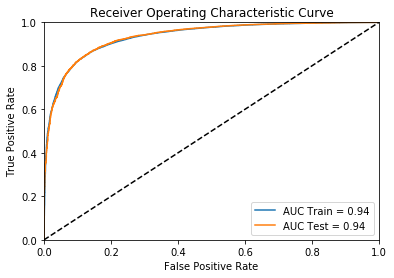

In [119]:
#plot roc curve for train and test data
plotROC(d_trainA_w2,y_train,d_testA_w2,y_test,lr_l2_tf_)

# [6] Conclusions

In [120]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Vectorising Method","Regularization", "Optimal C", "AUC Score","Precision", "Recall", "F1-Score"]

pt.add_row(["Bag Of Words","L1", 1, 0.934, 0.91, 0.90, 0.90 ])
pt.add_row(["","L2", 0.01, 0.940, 0.91, 0.88, 0.89])
pt.add_row(["Tf-Idf","L1", 1, 0.962, 0.93, 0.91, 0.91 ])
pt.add_row(["","L2", 10, 0.964, 0.93, 0.93, 0.93 ])
pt.add_row(["AV-W2V","L1", 1, 0.906, 0.88, 0.81, 0.83 ])
pt.add_row(["","L2", 1, 0.906, 0.88, 0.82, 0.83 ])
pt.add_row(["TfIdf-W2V","L1", 1, 0.881, 0.87, 0.79, 0.82 ])
pt.add_row(["","L2", 1, 0.881, 0.87, 0.79, 0.82 ])
pt.add_row(["Rev+Sum with AV-W2V","L2", 1, 0.934, 0.90, 0.85, 0.86 ])


print(pt)
print("\n\n Note: Auc Score, Precision, Recall and F1- Score are on Test Data")



+---------------------+----------------+-----------+-----------+-----------+--------+----------+
|  Vectorising Method | Regularization | Optimal C | AUC Score | Precision | Recall | F1-Score |
+---------------------+----------------+-----------+-----------+-----------+--------+----------+
|     Bag Of Words    |       L1       |     1     |   0.934   |    0.91   |  0.9   |   0.9    |
|                     |       L2       |    0.01   |    0.94   |    0.91   |  0.88  |   0.89   |
|        Tf-Idf       |       L1       |     1     |   0.962   |    0.93   |  0.91  |   0.91   |
|                     |       L2       |     10    |   0.964   |    0.93   |  0.93  |   0.93   |
|        AV-W2V       |       L1       |     1     |   0.906   |    0.88   |  0.81  |   0.83   |
|                     |       L2       |     1     |   0.906   |    0.88   |  0.82  |   0.83   |
|      TfIdf-W2V      |       L1       |     1     |   0.881   |    0.87   |  0.79  |   0.82   |
|                     |       

1) We achieved the highest AUC score after vectorization by *TF-IDF* method and using *L2* regularizer. The score is 0.964.

2) The sparcity is *decreasing* as Lambda is *increasing* in the sparcity test as expected.

3) 50 features are found to be multi-collinear in the pertubation test done after vectorising with BOW and using L2 regulariser.

4) Most of the words are common in top 10 neagtive words using Bag of Words and Tf-Idf.

5) Most of the words are common in top 10 Positive words using Bag of Words and Tf-Idf.

6) The lowest ROC-AUC score is achieved after vectorization by *Tf-Idf weighted Word2Vec*. The score is 0.887.

7) We can say that model is very good in predicting positive reviews looking at the Precision, Recall and F1-score.

8) The model performance improved drastically after including the parameter *class-weight='balanced'* in the model.

9) The AUC score for Average W2V featurization has improved after adding the summary as feature by 3%.

10) The best value of C, the hyperparameter, remains same from grid search and from Train vs Test AUC score plot on C.